# Variability analysis for HBEC IFN experiment

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline
import itertools

In [2]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq')
import encode
import memento

In [3]:
data_path = '/data_volume/ifn_hbec/'
fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig6/'

In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

### Read the processed RNA data

Focus on the club and bc/club cells and type I interferons for now.

Encode the timestamps to integers.

In [7]:
# adata_processed = sc.read(data_path + 'HBEC_type_I_processed_deep.h5ad')

In [8]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

In [9]:
adata = adata[:, ~adata.var.index.str.startswith('MT-')].copy()
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'basal/club' else 'bc')
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'ionocyte/tuft' else 'ion-tuft')

In [10]:
adata.shape

(69958, 36588)

### Read 1d HT result comparing to control

In [57]:
cts = [['ciliated'], ['bc', 'basal']]
tps = ['3', '6', '9', '24', '48']
stims = ['alpha', 'beta', 'gamma', 'lambda']

In [58]:
def read_result(ct):
    
    ht_dict = {}
    moments_dict = {}
    
    for stim in stims:
        ht_dict[stim] = {}
        moments_dict[stim] = {}
        for tp in tps: 
            adata_subset = sc.read('/data_volume/ifn_hbec/binary_test_deep/{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp))
            ht_dict[stim][tp] = memento.get_1d_ht_result(adata_subset)
            ht_dict[stim][tp]['de_fdr'] = memento.util._fdrcorrect(ht_dict[stim][tp]['de_pval'])
            ht_dict[stim][tp]['dv_fdr'] = memento.util._fdrcorrect(ht_dict[stim][tp]['dv_pval'])
            moments_dict[stim][tp] = memento.get_1d_moments(adata_subset, groupby='time_step')
    return ht_dict,moments_dict

In [59]:
all_result = {}
for ct in cts:
    
    key = '-'.join(ct)
    all_result[key] = {}
    
    all_result[key]['ht'], all_result[key]['moments'] = read_result(ct)

In [15]:
dv_genes = set()
de_genes = set()
all_genes = set()
for ct in cts:
    
    key = '-'.join(ct)    
    df = all_result[key]['ht']
    
    for stim in stims:
        for tp in tps:
            all_genes |= set(all_result[key]['ht'][stim][tp].gene.tolist())
            de_genes |= set(all_result[key]['ht'][stim][tp].query('de_fdr < 0.05').gene.tolist())
            dv_genes |= set(all_result[key]['ht'][stim][tp].query('dv_fdr < 0.1').gene.tolist())

In [16]:
all_result['ciliated']['ht']['beta']['3'].head(5)

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_fdr,dv_fdr
0,LINC01409,0.269090,0.135810,0.047495,0.619429,0.737656,3.365663e-01,0.089426,7.018107e-01
1,NOC2L,0.069103,0.091108,0.448055,-0.156447,0.744702,8.022198e-01,0.556792,9.368110e-01
2,HES4,0.618335,0.050295,0.000008,0.036485,0.148947,8.047195e-01,0.000055,9.375526e-01
3,ISG15,2.725120,0.072049,0.000001,-2.478389,0.170019,3.137984e-35,0.000009,3.025644e-31
4,AGRN,0.897875,0.070454,0.000005,-0.099188,0.332871,7.491251e-01,0.000037,9.155868e-01


In [104]:
def plot_de_dv(result_df):
    
    de_diff = result_df['de_coef']
    dv_diff = result_df['dv_coef']
    de_fdr = result_df['de_fdr']
    dv_fdr = result_df['dv_fdr']
    
    plt.plot([0, 0], [np.nanmin(dv_diff), np.nanmax(dv_diff)], '--', lw=2, color='k')
    plt.plot([np.nanmin(de_diff), np.nanmax(de_diff)], [0, 0], '--', lw=2, color='k')
    
    de_sig = de_fdr < 0.05
    dv_sig = (dv_fdr < 0.1)
    dv_inc = dv_diff > 0
    dv_dec = dv_diff < 0
    
#     both_sig = de_sig & dv_sig

    plt.scatter(de_diff, dv_diff, s=1, color='grey', zorder=-1)
#     plt.scatter(de_diff[de_sig], dv_diff[de_sig], s=1, color='b')
    plt.scatter(de_diff[dv_sig & dv_inc], dv_diff[dv_sig & dv_inc], s=3, color='c', zorder=10)
    plt.scatter(de_diff[dv_sig & dv_dec], dv_diff[dv_sig & dv_dec], s=3, color='m', zorder=10)

#     plt.scatter(de_diff[both_sig], dv_diff[both_sig], s=1, color='m')
#     plt.xlim(-0.1, .1);
#     plt.ylim(-0.5, 0.3)
        
    plt.xlabel('$\Delta$Mean')
    plt.ylabel('$\Delta$Variability')
    
#     print(util.robust_correlation(de_diff[de_sig & dv_sig], dv_diff[de_sig & dv_sig]))

#     plt.title(label_converter[ct])
#     plt.gca().xaxis.set_major_locator(plt.MultipleLocator(0.1))
#     plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.255))

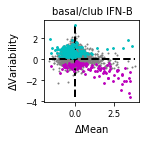

In [106]:
plt.figure(figsize=(1.7, 1.5))
plot_de_dv(all_result['bc-basal']['ht']['beta']['6'])
plt.title('basal/club IFN-B')
plt.savefig(fig_path + 'scatter_hbec_beta_bc.png', bbox_inches='tight', dpi=300)


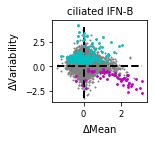

In [34]:
plt.figure(figsize=(1.7, 1.5))
plot_de_dv(all_result['ciliated']['ht']['beta']['6'])
plt.title('ciliated IFN-B')
plt.savefig(fig_path + 'scatter_hbec_beta.png', bbox_inches='tight', dpi=300)


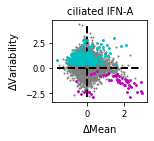

In [35]:
plt.figure(figsize=(1.7, 1.5))
plot_de_dv(all_result['ciliated']['ht']['alpha']['6'])
plt.title('ciliated IFN-A')
plt.savefig(fig_path + 'scatter_hbec_alpha.png', bbox_inches='tight', dpi=300)


In [38]:
stats.spearmanr(
    all_result['ciliated']['ht']['alpha']['6'].de_coef,
    all_result['ciliated']['ht']['alpha']['6'].dv_coef)

SpearmanrResult(correlation=-0.20350205187874654, pvalue=8.17887784358328e-87)

In [111]:
stats.spearmanr(
    all_result['bc-basal']['ht']['beta']['6'].de_coef,
    all_result['bc-basal']['ht']['beta']['6'].dv_coef)

SpearmanrResult(correlation=-0.09265385773160449, pvalue=5.864851408053831e-17)

In [39]:
stats.spearmanr(
    all_result['ciliated']['ht']['beta']['6'].de_coef,
    all_result['ciliated']['ht']['beta']['6'].dv_coef)

SpearmanrResult(correlation=-0.14469855064477544, pvalue=2.176507671411776e-46)

### Dec var genes

In [113]:
for g in all_result['ciliated']['ht']['beta']['6'].query('dv_coef < 0 & dv_fdr < 0.1').gene.tolist():
    print(g)

ISG15
IFI6
MARCKSL1
IFI44L
IFI44
CAPN2
CMPK2
RSAD2
EIF2AK2
PARP9
PARP14
PPP2R3A
PLSCR1
RTP4
CD38
CXCL1
HERC6
HERC5
DDX60
DDX60L
CD74
HLA-A
HLA-B
CFB
HLA-DRA
HLA-DMA
SAMD9
SAMD9L
PTN
DDX58
MSMB
IFIT2
IFIT3
IFIT1
IFITM2
IFITM1
IFITM3
IRF7
TSPAN8
OAS1
OAS3
EPSTI1
CLDN10
NFKBIA
IFI27
ISG20
MT2A
ZZEF1
XAF1
RNF213
SERPINB3
C3
BST2
CLEC11A
BPIFB1
MX2
MX1


### Get genes that are likely ISGF3 binding

In [114]:
enc = encode.Encode('/data/home/Github/misc-seq/miscseq/GRCh38Genes.bed')

In [115]:
stat1_bed = enc.get_encode_peaks_union([
    'https://www.encodeproject.org/files/ENCFF747ICD/@@download/ENCFF747ICD.bed.gz',
    'https://www.encodeproject.org/files/ENCFF646MXG/@@download/ENCFF646MXG.bed.gz'
])
stat2_bed = enc.get_encode_peaks_union([
    'https://www.encodeproject.org/files/ENCFF204VQS/@@download/ENCFF204VQS.bed.gz',
    'https://www.encodeproject.org/files/ENCFF545JVD/@@download/ENCFF545JVD.bed.gz'
])

In [116]:
intersect_bed = stat1_bed.intersect(stat2_bed).sort()

In [117]:
isgf3_genes = enc.get_peak_genes_bed(intersect_bed, 0).query('distance == 0 & ~gene.str.contains("MT").values').gene.tolist()

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/pybedtools/bedtool.py:3681: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 16 fields; you can supply custom names with the `names` kwarg
  "`names` kwarg" % (self.file_type, _names, self.field_count())


### Get genes that are likely GAF binding

In [118]:
stat1_bed = enc.get_encode_peaks_union([
    'https://www.encodeproject.org/files/ENCFF431NLF/@@download/ENCFF431NLF.bed.gz',
    'https://www.encodeproject.org/files/ENCFF646MXG/@@download/ENCFF646MXG.bed.gz'
])

In [119]:
potential_gaf_genes = enc\
    .get_peak_genes_encode('https://www.encodeproject.org/files/ENCFF431NLF/@@download/ENCFF431NLF.bed.gz', 0)\
    .query('distance == 0 & ~gene.str.contains("MT").values').gene.tolist()

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/pybedtools/bedtool.py:3681: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 16 fields; you can supply custom names with the `names` kwarg
  "`names` kwarg" % (self.file_type, _names, self.field_count())


In [120]:
baseline_stat1_genes = enc\
    .get_peak_genes_encode('https://www.encodeproject.org/files/ENCFF323QQU/@@download/ENCFF323QQU.bed.gz', 0)\
    .query('distance == 0 & ~gene.str.contains("MT").values').gene.tolist()

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/pybedtools/bedtool.py:3681: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 16 fields; you can supply custom names with the `names` kwarg
  "`names` kwarg" % (self.file_type, _names, self.field_count())


In [121]:
gaf_genes =potential_gaf_genes #list(set(potential_gaf_genes) - set(baseline_stat1_genes))

### CHIP-seq result, ISGF3

In [122]:
all_result['ciliated']['ht'].keys()

dict_keys(['alpha', 'beta', 'gamma', 'lambda'])

In [123]:
def classify_gene(x):
    
    isgf3 = x in isgf3_genes
    gaf = x in gaf_genes
    
    if gaf & isgf3:
        return ['isgf3', 'gaf']
    elif gaf:
        return ['gaf']
    elif isgf3:
        return ['isgf3']
    else:
        return ['rest']

beta_dfs = []
for ct in cts:
    
    result_1d_stim = all_result['-'.join(ct)]['ht']['beta']['3']
    result_1d_stim['isgf3'] = result_1d_stim.gene.apply(lambda x: 'in TSS' if x in isgf3_genes else 'rest')
    result_1d_stim['gaf'] = result_1d_stim.gene.apply(lambda x: x in gaf_genes)
#     result_1d_stim['cat'] = result_1d_stim.gene.apply(classify_gene)
    result_1d_stim['de_fdr'] = memento.util._fdrcorrect(result_1d_stim['de_pval'])

    upreg_1d_stim = result_1d_stim.query('de_fdr < 0.1 & de_coef > 0 & ~gene.str.contains("MT-").values').copy()
    upreg_1d_stim['ct'] = '-'.join(ct)
    beta_dfs.append(upreg_1d_stim)
beta_df = pd.concat(beta_dfs)

alpha_dfs = []
for ct in cts:
    
    result_1d_stim = all_result['-'.join(ct)]['ht']['alpha']['3']
    result_1d_stim['isgf3'] = result_1d_stim.gene.apply(lambda x: 'in TSS' if x in isgf3_genes else 'rest')
    result_1d_stim['gaf'] = result_1d_stim.gene.apply(lambda x: x in gaf_genes)
#     result_1d_stim['cat'] = result_1d_stim.gene.apply(classify_gene)
    result_1d_stim['de_fdr'] = memento.util._fdrcorrect(result_1d_stim['de_pval'])

    upreg_1d_stim = result_1d_stim.query('de_fdr < 0.1 & de_coef > 0 & ~gene.str.contains("MT-").values').copy()
    upreg_1d_stim['ct'] = '-'.join(ct)
    alpha_dfs.append(upreg_1d_stim)
alpha_df = pd.concat(alpha_dfs)


In [ ]:
plt.figure(figsize=(1.2, 3))
sns.boxplot(x='ct', y='dv_coef', hue='isgf3', data=alpha_df.sort_values('isgf3'), palette='Set2')

plt.xlabel('Cell type'); plt.ylabel('Change in variability');
plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.15))
# plt.ylim(-.8, 0.6)
# plt.savefig(fig_path + 'isgf3_vs_rest_var_alpha.pdf', bbox_inches='tight')



In [129]:
stats.mannwhitneyu(
    alpha_df.query('isgf3 == "in TSS"').de_coef.values,
    alpha_df.query('isgf3 == "rest"').de_coef.values)

MannwhitneyuResult(statistic=151136.0, pvalue=4.53057179018355e-54)

In [130]:
stats.mannwhitneyu(
    beta_df.query('isgf3 == "in TSS"').de_coef.values,
    beta_df.query('isgf3 == "rest"').de_coef.values)

MannwhitneyuResult(statistic=171259.0, pvalue=2.288572030286872e-54)

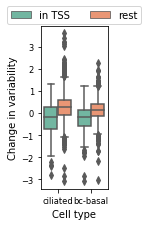

In [109]:
plt.figure(figsize=(1.2, 3))
sns.boxplot(x='ct', y='dv_coef', hue='isgf3', data=alpha_df.sort_values('isgf3'), palette='Set2')

plt.xlabel('Cell type'); plt.ylabel('Change in variability');
plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.15))
# plt.ylim(-.8, 0.6)
plt.savefig(fig_path + 'isgf3_vs_rest_var_alpha.pdf', bbox_inches='tight')



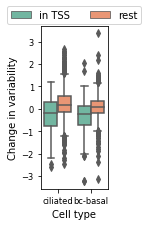

In [110]:
plt.figure(figsize=(1.2, 3))
sns.boxplot(x='ct', y='dv_coef', hue='isgf3', data=beta_df.sort_values('isgf3'), palette='Set2')

plt.xlabel('Cell type'); plt.ylabel('Change in variability');
plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.15))
# plt.ylim(-.8, 0.6)
plt.savefig(fig_path + 'isgf3_vs_rest_var_beta.pdf', bbox_inches='tight')



### Some basic enrichment analysis - increased variance

In [12]:
stim = 'gamma'
gene_list = []
for tp in tps[1:]:
    df = all_result['bc-basal']['ht'][stim][tp].query('dv_coef > 0 & dv_fdr < 0.1 & de_coef > 0')
    gene_list += df.gene.tolist()
gene_list = list(set(gene_list))

### Setup memento

In [79]:
def assign_q(batch):
    
    if batch == 0:
        return 0.387*0.25
    elif batch == 1:
        return 0.392*0.25
    elif batch == 2:
        return 0.436*0.25
    else:
        return 0.417*0.25

In [80]:
adata.obs['q'] = adata.obs['batch'].apply(assign_q)

In [81]:
memento.setup_memento(adata, q_column='q')

### Pick top regulators

In [82]:
expr_df = pd.DataFrame()
expr_df['gene'] = adata.var.index.tolist()
expr_df['expr'] = adata.uns['memento']['all_1d_moments'][0]
filtered_tfs = expr_df.query('gene in @tfs').sort_values('expr', ascending=False).head(70).gene.tolist()

### Get correlated TFs for each gene in each state

In [16]:
cts = [['ciliated']]
tps = ['3', '6', '9', '24', '48']
stims = ['alpha']

In [99]:
def get_tf_g_vars(stim, ct, logfc=1):
    
    g_mean_list = []
    tf_mean_list = []
    g_var_list = []
    tf_var_list = []
    for tp in ['0','3', '6', '9', '24', '48']:

        ctrl_gene_list = []
        for tp2 in tps[1:]:
            df = all_result['-'.join(ct)]['ht'][stim][tp2].query('de_coef > {} & de_fdr < 0.05'.format(logfc))
            ctrl_gene_list += df.gene.tolist()

        print('starting', ct, tp, stim)

        adata_stim = adata.copy()[
            adata.obs.cell_type.isin(ct) & \
            adata.obs.stim.isin(['control', stim]) & \
            adata.obs.time.isin([tp]), :].copy()
        time_converter={int(tp):1}
        adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

        memento.create_groups(adata_stim, label_columns=['donor', 'time_step'])
        memento.compute_1d_moments(adata_stim, min_perc_group=.8)

        relevant_tfs = list(set(tfs) & set(adata_stim.var.index))
        gene_list = list(set(ctrl_gene_list) & set(adata_stim.var.index))

        memento.compute_2d_moments(adata_stim, list(itertools.product(relevant_tfs, gene_list)))

        moment_2d = memento.get_2d_moments(adata_stim, groupby='time_step')
        moment_1d_mean = memento.get_1d_moments(adata_stim, groupby='time_step')[0]
        moment_1d = memento.get_1d_moments(adata_stim, groupby='time_step')[1]

        moment_1d.to_csv('/data_volume/ifn_hbec/corr_var/{}_{}_{}_1d.csv'.format('-'.join(ct), stim, tp), index=False)
        moment_2d.to_csv('/data_volume/ifn_hbec/corr_var/{}_{}_{}_2d.csv'.format('-'.join(ct), stim, tp), index=False)

        high_corr_tfs = moment_2d.query('time_step_1 > 0.3 & gene_1 != gene_2', engine='python').groupby('gene_2').gene_1.apply(list)
        

        g_var = []
        tf_var = []
        g_mean = []
        tf_mean = []
        for gene in gene_list:

            if not gene in high_corr_tfs.index:
                continue
                
            g_mean.append(moment_1d_mean.query('gene == "{}"'.format(gene)).values[0, 1])
            g_var.append(moment_1d.query('gene == "{}"'.format(gene)).values[0, 1])
            ts = high_corr_tfs[gene]
        #     tf_var.append(len(ts))
            tf_var.append(np.mean(moment_1d.query('gene.isin(@ts)', engine='python').values[:, 1]))
            tf_mean.append(np.mean(moment_1d_mean.query('gene.isin(@ts)', engine='python').values[:, 1]))

        print(stats.pearsonr(g_var, tf_var))
        print(stats.pearsonr(g_mean, tf_mean))

        g_var_list.append(np.array(g_var))
        g_mean_list.append(np.array(g_mean))
        tf_var_list.append(np.array(tf_var))
        tf_mean_list.append(np.array(tf_mean))
        
    return g_var_list,g_mean_list, tf_var_list, tf_mean_list
        
    return np.concatenate(g_var_list), \
        np.concatenate(tf_var_list), \
        np.concatenate(g_mean_list),\
        np.concatenate(tf_mean_list)


### Beta

In [100]:
g, gm, t, tm = get_tf_g_vars('beta', ['ciliated'], logfc=0.5)
# sns.regplot(g,t,scatter_kws={'s':1}, line_kws={'color':'black', 'lw':3})
# plt.title('Lambda'); plt.xlabel('Gene variability'); plt.ylabel('TF variability')

starting ['ciliated'] 0 beta
(0.14070976650728795, 0.0012405791009370208)
(0.2576835515712103, 2.151444202893076e-09)
starting ['ciliated'] 3 beta
(0.3305478276744429, 1.432501378989128e-18)
(0.5085729396222846, 2.0154191422706976e-45)
starting ['ciliated'] 6 beta
(0.4902605523050945, 2.4023269950773128e-45)
(0.5891424185904743, 2.5070577388180277e-69)
starting ['ciliated'] 9 beta
(0.2728469217972776, 1.8178082246886964e-13)
(0.5634472956527685, 3.852917020506383e-60)
starting ['ciliated'] 24 beta
(0.18290774984311678, 8.045796487266726e-07)
(0.5673526374854918, 2.1129677004463828e-62)
starting ['ciliated'] 48 beta
(0.0568577097048396, 0.1309507451861645)
(0.44985791376132855, 1.6100459080041258e-36)


In [50]:
g, gm, t, tm = get_tf_g_vars('beta', ['ciliated'], logfc=0.5)
# sns.regplot(g,t,scatter_kws={'s':1}, line_kws={'color':'black', 'lw':3})
# plt.title('Lambda'); plt.xlabel('Gene variability'); plt.ylabel('TF variability')

starting ['ciliated'] 0 beta


/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.4-py3.7.egg/memento/main.py:578: RuntimeWarning: invalid value encountered in true_divide
  groupby_corr[key] /= groupby_corr_count[key]


(0.14393203395489962, 0.0009527972593742623)
(0.2612420999648299, 1.2666258382698528e-09)
starting ['ciliated'] 3 beta
(0.33228417454233217, 9.248132291717018e-19)
(0.5119456646710474, 4.221776975197336e-46)
starting ['ciliated'] 6 beta
(0.4938424026876681, 4.3981449301893384e-46)
(0.5907355445766977, 8.767137382581865e-70)
starting ['ciliated'] 9 beta
(0.2748313842461405, 1.1958009766540618e-13)
(0.5656289297973948, 1.0808655836166295e-60)
starting ['ciliated'] 24 beta
(0.18448109277419109, 6.443170094804263e-07)
(0.5693761561170528, 6.238423359114057e-63)
starting ['ciliated'] 48 beta
(0.059400996395567895, 0.11455643295259538)
(0.4524175808224378, 5.760990308339558e-37)


<Figure size 144x144 with 0 Axes>

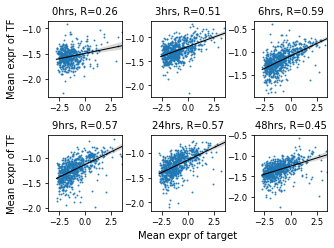

In [67]:
# ylim_list = [(-0.25, 0.25), (-0.35, 0.25), (-0.3, 0.5), (-0.25, 0.55), (-0.27, 0.55), (-0.27, 0.5)]
plt.figure(figsize=(5, 3.5));
plt.subplots_adjust(wspace=0.4, hspace=0.5)
for idx in range(6):
    plt.subplot(2, 3, idx+1)
    sns.regplot(gm[idx],tm[idx],scatter_kws={'s':1}, line_kws={'color':'black', 'lw':1})
    plt.xlim(-3.5, 3.5); #plt.ylim(ylim_list[idx][0], ylim_list[idx][1])
    plt.title('{}hrs, R={:.2f}'.format([0, 3, 6, 9, 24, 48][idx], stats.pearsonr(gm[idx],tm[idx])[0]))
    if idx == 0 or idx == 3:
        plt.ylabel('Mean expr of TF')
    if idx == 4:
        plt.xlabel('Mean expr of target')
plt.savefig(fig_path + 'var_regplot_mean_beta.png', bbox_inches='tight', dpi=300)


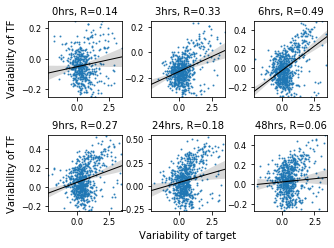

In [68]:
ylim_list = [(-0.25, 0.25), (-0.35, 0.25), (-0.3, 0.5), (-0.25, 0.55), (-0.27, 0.55), (-0.27, 0.5)]
plt.figure(figsize=(5, 3.5));
plt.subplots_adjust(wspace=0.4, hspace=0.5)
for idx in range(6):
    plt.subplot(2, 3, idx+1)
    sns.regplot(g[idx],t[idx],scatter_kws={'s':1}, line_kws={'color':'black', 'lw':1})
    plt.xlim(-2.2, 3.5); plt.ylim(ylim_list[idx][0], ylim_list[idx][1])
    plt.title('{}hrs, R={:.2f}'.format([0, 3, 6, 9, 24, 48][idx], stats.pearsonr(g[idx],t[idx])[0]))
    
    if idx == 0 or idx == 3:
        plt.ylabel('Variability of TF')
    if idx == 4:
        plt.xlabel('Variability of target')
plt.savefig(fig_path + 'var_regplot_beta.png', bbox_inches='tight', dpi=300)


### Gamma

In [19]:
plt.figure(figsize=(2, 2))
g, gm, t, tm = get_tf_g_vars('gamma', ['ciliated'], logfc=0.5)
# sns.regplot(g,t,scatter_kws={'s':1}, line_kws={'color':'black', 'lw':3})
# plt.title('Lambda'); plt.xlabel('Gene variability'); plt.ylabel('TF variability')

starting ['ciliated'] 0 gamma
(0.17348167278862386, 0.0025260406062387218)
(0.19480394506515422, 0.0006781268550281566)
starting ['ciliated'] 3 gamma
(0.22614618611939474, 3.641548534312262e-06)
(0.44521704581465227, 2.1016309648491273e-21)
starting ['ciliated'] 6 gamma
(0.089475899868865, 0.06346819018064322)
(0.3458510629927055, 1.4857310744787437e-13)
starting ['ciliated'] 9 gamma
(0.12126413110250177, 0.010114920814816575)
(0.3589608043739944, 4.223177031340322e-15)
starting ['ciliated'] 24 gamma
(0.2571182273500052, 4.494013917604965e-08)
(0.3781439714012768, 2.094896261890795e-16)
starting ['ciliated'] 48 gamma
(0.028228426724251198, 0.5561769089405298)
(0.25327134847831567, 8.000698271065925e-08)


<Figure size 144x144 with 0 Axes>

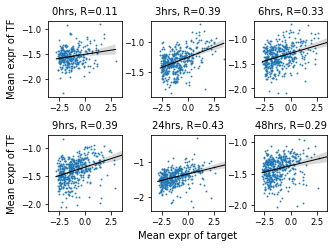

In [22]:
# ylim_list = [(-0.25, 0.25), (-0.35, 0.25), (-0.3, 0.5), (-0.25, 0.55), (-0.27, 0.55), (-0.27, 0.5)]
plt.figure(figsize=(5, 3.5));
plt.subplots_adjust(wspace=0.4, hspace=0.5)
for idx in range(6):
    plt.subplot(2, 3, idx+1)
    sns.regplot(gm[idx],tm[idx],scatter_kws={'s':1}, line_kws={'color':'black', 'lw':1})
    plt.xlim(-3.5, 3.5); #plt.ylim(ylim_list[idx][0], ylim_list[idx][1])
    plt.title('{}hrs, R={:.2f}'.format([0, 3, 6, 9, 24, 48][idx], stats.spearmanr(gm[idx],tm[idx])[0]))
    if idx == 0 or idx == 3:
        plt.ylabel('Mean expr of TF')
    if idx == 4:
        plt.xlabel('Mean expr of target')
plt.savefig(fig_path + 'var_regplot_mean_gamma.png', bbox_inches='tight', dpi=300)


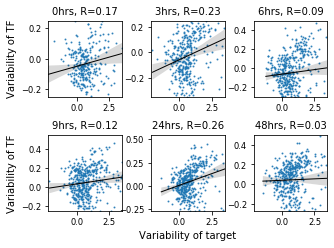

In [24]:
ylim_list = [(-0.25, 0.25), (-0.35, 0.25), (-0.3, 0.5), (-0.25, 0.55), (-0.27, 0.55), (-0.27, 0.5)]
plt.figure(figsize=(5, 3.5));
plt.subplots_adjust(wspace=0.4, hspace=0.5)
for idx in range(6):
    plt.subplot(2, 3, idx+1)
    sns.regplot(g[idx],t[idx],scatter_kws={'s':1}, line_kws={'color':'black', 'lw':1})
    plt.xlim(-2.2, 3.5); plt.ylim(ylim_list[idx][0], ylim_list[idx][1])
    plt.title('{}hrs, R={:.2f}'.format([0, 3, 6, 9, 24, 48][idx], stats.pearsonr(g[idx],t[idx])[0]))
    
    if idx == 0 or idx == 3:
        plt.ylabel('Variability of TF')
    if idx == 4:
        plt.xlabel('Variability of target')
plt.savefig(fig_path + 'var_regplot_gamma.png', bbox_inches='tight', dpi=300)


### Lambda

In [25]:
plt.figure(figsize=(2, 2))
g, gm, t, tm = get_tf_g_vars('lambda', ['ciliated'], logfc=0.5)
# sns.regplot(g,t,scatter_kws={'s':1}, line_kws={'color':'black', 'lw':3})
# plt.title('Lambda'); plt.xlabel('Gene variability'); plt.ylabel('TF variability')

starting ['ciliated'] 0 lambda


/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.4-py3.7.egg/memento/main.py:578: RuntimeWarning: invalid value encountered in true_divide


(0.24601790426695566, 0.0005266879260518222)
(0.1552093219074313, 0.030265946566208356)
starting ['ciliated'] 3 lambda
(0.5601861538561371, 2.7055967186244606e-23)
(0.40834498957685444, 4.517919397901384e-12)
starting ['ciliated'] 6 lambda
(0.3505066752785005, 2.786530906821842e-09)
(0.2471904563751262, 3.753628061637839e-05)
starting ['ciliated'] 9 lambda
(0.5038161111749582, 9.451739529902435e-20)
(0.3376369097278771, 4.98934963839756e-09)
starting ['ciliated'] 24 lambda
(0.3309451661002548, 7.695458027398483e-09)
(0.20693467138387314, 0.0003893162580468685)
starting ['ciliated'] 48 lambda
(0.43562797929280206, 3.283121296511646e-14)
(0.30076115747381404, 3.5368397192830473e-07)


<Figure size 144x144 with 0 Axes>

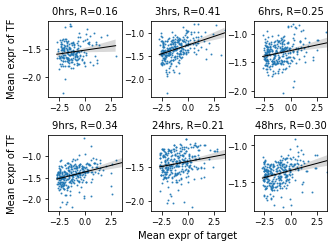

In [26]:
# ylim_list = [(-0.25, 0.25), (-0.35, 0.25), (-0.3, 0.5), (-0.25, 0.55), (-0.27, 0.55), (-0.27, 0.5)]
plt.figure(figsize=(5, 3.5));
plt.subplots_adjust(wspace=0.4, hspace=0.5)
for idx in range(6):
    plt.subplot(2, 3, idx+1)
    sns.regplot(gm[idx],tm[idx],scatter_kws={'s':1}, line_kws={'color':'black', 'lw':1})
    plt.xlim(-3.5, 3.5); #plt.ylim(ylim_list[idx][0], ylim_list[idx][1])
    plt.title('{}hrs, R={:.2f}'.format([0, 3, 6, 9, 24, 48][idx], stats.pearsonr(gm[idx],tm[idx])[0]))
    if idx == 0 or idx == 3:
        plt.ylabel('Mean expr of TF')
    if idx == 4:
        plt.xlabel('Mean expr of target')
plt.savefig(fig_path + 'var_regplot_mean_lambda.png', bbox_inches='tight', dpi=300)


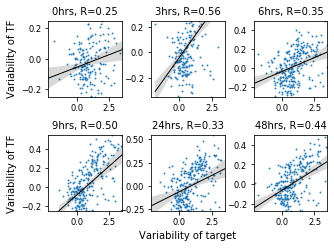

In [27]:
ylim_list = [(-0.25, 0.25), (-0.35, 0.25), (-0.3, 0.5), (-0.25, 0.55), (-0.27, 0.55), (-0.27, 0.5)]
plt.figure(figsize=(5, 3.5));
plt.subplots_adjust(wspace=0.4, hspace=0.5)
for idx in range(6):
    plt.subplot(2, 3, idx+1)
    sns.regplot(g[idx],t[idx],scatter_kws={'s':1}, line_kws={'color':'black', 'lw':1})
    plt.xlim(-2.2, 3.5); plt.ylim(ylim_list[idx][0], ylim_list[idx][1])
    plt.title('{}hrs, R={:.2f}'.format([0, 3, 6, 9, 24, 48][idx], stats.pearsonr(g[idx],t[idx])[0]))
    
    if idx == 0 or idx == 3:
        plt.ylabel('Variability of TF')
    if idx == 4:
        plt.xlabel('Variability of target')
plt.savefig(fig_path + 'var_regplot_lambda.png', bbox_inches='tight', dpi=300)


### TF-Target mean/variability analysis but with CHIP-Seq data

In [47]:
chip_matrix = pd.read_csv('gene_attribute_matrix.txt', sep='\t')
chip_matrix.drop(chip_matrix.columns[1], axis=1,inplace=True)
chip_matrix.drop(chip_matrix.columns[1], axis=1,inplace=True)
chip_matrix.drop(0, inplace=True)
chip_matrix.drop(1, inplace=True)
# chip_matrix.index = chip_matrix['#']
# chip_matrix.drop('#', axis=1, inplace=True)

In [62]:
chip_matrix_long = pd.melt(
    chip_matrix, 
    id_vars='#',
    value_vars=chip_matrix.columns[1:],
    var_name='TF',
    value_name='binding'
    )

In [63]:
chip_matrix_long['binding'] = chip_matrix_long['binding'].astype(float)

In [64]:
chip_matrix_long = chip_matrix_long.query('binding > 0').rename(columns={'#':'gene'})

In [68]:
chip_matrix_long.head(2)

,gene,TF,binding
0,A1BG,ARID3A,1.0
1,A1BG-AS1,ARID3A,1.0


In [83]:
def get_tf_g_vars_chip(stim, ct, logfc=1):
    
    g_mean_list = []
    tf_mean_list = []
    g_var_list = []
    tf_var_list = []
    for tp in ['0','3', '6', '9', '24', '48']:

        ctrl_gene_list = []
        for tp2 in tps[1:]:
            df = all_result['-'.join(ct)]['ht'][stim][tp2].query('de_coef > {} & de_fdr < 0.05'.format(logfc))
            ctrl_gene_list += df.gene.tolist()

        print('starting', ct, tp, stim)

        adata_stim = adata.copy()[
            adata.obs.cell_type.isin(ct) & \
            adata.obs.stim.isin(['control', stim]) & \
            adata.obs.time.isin([tp]), :].copy()
        time_converter={int(tp):1}
        adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

        memento.create_groups(adata_stim, label_columns=['donor', 'time_step'])
        memento.compute_1d_moments(adata_stim, min_perc_group=.8)

        relevant_tfs = list(set(tfs) & set(adata_stim.var.index))
        gene_list = list(set(ctrl_gene_list) & set(adata_stim.var.index))

#         memento.compute_2d_moments(adata_stim, list(itertools.product(relevant_tfs, gene_list)))

#         moment_2d = memento.get_2d_moments(adata_stim, groupby='time_step')
        moment_1d_mean = memento.get_1d_moments(adata_stim, groupby='time_step')[0]
        moment_1d = memento.get_1d_moments(adata_stim, groupby='time_step')[1]

#         moment_1d.to_csv('/data_volume/ifn_hbec/corr_var/{}_{}_{}_1d.csv'.format('-'.join(ct), stim, tp), index=False)
#         moment_2d.to_csv('/data_volume/ifn_hbec/corr_var/{}_{}_{}_2d.csv'.format('-'.join(ct), stim, tp), index=False)
        
        relevant_chip = chip_matrix_long.query('gene in @gene_list & TF in @relevant_tfs')
        high_corr_tfs = relevant_chip.groupby('gene').TF.apply(list)
#         high_corr_tfs = moment_2d.query('time_step_1 > 0.3', engine='python').groupby('gene_2').gene_1.apply(list)

        g_var = []
        tf_var = []
        g_mean = []
        tf_mean = []
        for gene in gene_list:

            if not gene in high_corr_tfs.index:
                continue
                
            g_mean.append(moment_1d_mean.query('gene == "{}"'.format(gene)).values[0, 1])
            g_var.append(moment_1d.query('gene == "{}"'.format(gene)).values[0, 1])
            ts = high_corr_tfs[gene]
        #     tf_var.append(len(ts))
            tf_var.append(np.mean(moment_1d.query('gene.isin(@ts)', engine='python').values[:, 1]))
            tf_mean.append(np.mean(moment_1d_mean.query('gene.isin(@ts)', engine='python').values[:, 1]))

        print(stats.pearsonr(g_var, tf_var))
        print(stats.pearsonr(g_mean, tf_mean))

        g_var_list.append(np.array(g_var))
        g_mean_list.append(np.array(g_mean))
        tf_var_list.append(np.array(tf_var))
        tf_mean_list.append(np.array(tf_mean))
        
    return g_var_list,g_mean_list, tf_var_list, tf_mean_list
        
    return np.concatenate(g_var_list), \
        np.concatenate(tf_var_list), \
        np.concatenate(g_mean_list),\
        np.concatenate(tf_mean_list)


In [84]:
g, gm, t, tm = get_tf_g_vars_chip('beta', ['ciliated'], logfc=0.5)


starting ['ciliated'] 0 beta
(-0.03611383150921946, 0.42460945747771817)
(0.03691688053292283, 0.4143762100852828)
starting ['ciliated'] 3 beta
(-0.053907242867429206, 0.17866382922133262)
(0.033071373845555974, 0.40954657118587656)
starting ['ciliated'] 6 beta
(-0.04138980218312124, 0.2821951162542153)
(0.06853414032471455, 0.07474833982803825)
starting ['ciliated'] 9 beta
(0.07030619162622699, 0.07325637846932749)
(0.10317927525353246, 0.008475112107104813)
starting ['ciliated'] 24 beta
(-0.0859985572923625, 0.026579843781861134)
(0.09218319998019517, 0.017417435338552365)
starting ['ciliated'] 48 beta
(-0.0379242430853652, 0.3325009538065924)
(0.07281991929175347, 0.06251976964630353)


### Compare to cM from PBMC data

In [89]:
pbmc_data_path = '/data_volume/parameter_estimation/'

In [90]:
cm_adata = sc.read(pbmc_data_path + 'result_1d/ifn/{}_20210104.h5ad'.format('cM'))

In [91]:
cm_ht_result_1d = memento.get_1d_ht_result(cm_adata)

In [92]:
joined = cm_ht_result_1d.merge(all_result['ciliated']['ht']['gamma']['3'], on='gene', how='inner')

In [ ]:
joined.head(5)

In [ ]:
stats.pearsonr(joined['de_coef_y'], joined['de_coef_x'])

In [62]:
stats.pearsonr(joined['dv_coef_y'], joined['dv_coef_x'])

(0.18189595294765162, 2.073095085778736e-11)

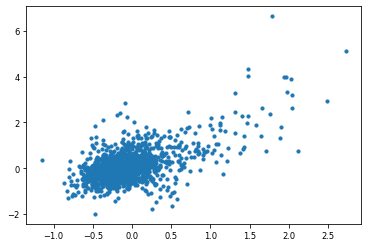

In [63]:
plt.scatter(joined['de_coef_y'], joined['de_coef_x'], s=10)

Text(0.5, 1.0, 'DV, PBMC vs IFN-B ciliated')

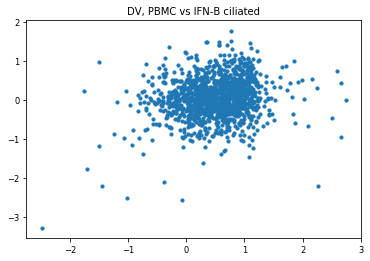

In [65]:
plt.scatter(joined['dv_coef_y'], joined['dv_coef_x'], s=10)
plt.title('DV, PBMC vs IFN-B ciliated')

In [66]:
joined.query('dv_coef_y < -0.5 & dv_coef_x < -0.5')

,gene,de_coef_x,de_se_x,de_pval_x,dv_coef_x,dv_se_x,dv_pval_x,de_coef_y,de_se_y,de_pval_y,dv_coef_y,dv_se_y,dv_pval_y,de_fdr,dv_fdr
0,ISG15,5.098154,0.073231,1.778018e-08,-3.274190,0.240614,2.771328e-44,2.725120,0.072049,1.071286e-06,-2.478389,0.170019,3.137984e-35,0.000009,3.025644e-31
30,IFI6,3.211037,0.055433,8.331472e-08,-1.770808,0.169302,6.521656e-23,2.035248,0.049066,1.867728e-06,-1.705210,0.140787,9.084616e-23,0.000016,2.189847e-19
71,GBP1,2.251378,0.047044,4.758652e-07,-0.750877,0.132809,5.248861e-09,1.151809,0.053890,1.852316e-06,-0.665419,0.317476,4.719528e-02,0.000016,3.129690e-01
225,STAT1,1.413377,0.059840,9.484251e-07,-0.767139,0.302698,2.519748e-02,1.431685,0.043994,7.398344e-07,-0.714755,0.211649,2.799720e-03,0.000007,4.127661e-02
279,ARF4,-0.288091,0.066921,6.019394e-05,-0.601691,0.446622,1.896810e-01,-0.049419,0.056178,3.792621e-01,-0.573384,0.300402,5.749425e-02,0.489406,3.462583e-01
542,SAMD9L,2.621440,0.072952,2.327380e-08,-0.980088,0.288240,1.309869e-02,2.037875,0.080411,6.150308e-07,-1.074292,0.323586,2.499750e-03,0.000006,3.850254e-02
731,IFITM2,3.271008,0.073602,5.020476e-05,-0.961744,0.224633,3.299670e-03,1.318253,0.070163,4.458285e-06,-0.806087,0.204675,4.137491e-07,0.000034,1.595747e-04
732,IFITM3,3.976847,0.072500,2.679437e-06,-2.502176,0.142980,4.059481e-24,1.932974,0.044457,1.991590e-07,-1.012494,0.173949,6.716627e-09,0.000002,4.047607e-06
851,USP15,1.110537,0.080291,1.724444e-05,-0.626781,0.419249,1.474853e-01,0.847357,0.076629,1.381537e-05,-0.524702,0.536557,2.623738e-01,0.000093,6.391632e-01
874,OAS1,3.331951,0.082338,5.337850e-07,-1.381646,0.174600,4.050953e-19,1.973972,0.071041,2.552064e-06,-0.745619,0.267849,1.549845e-02,0.000021,1.559875e-01


### IFN-A vs IFN-B

In [40]:
stims 

['alpha', 'beta', 'gamma', 'lambda']

alpha beta 0 1
de r (0.9463527975550924, 0.0)
dv r (0.6287114187691951, 0.0)
alpha gamma 0 2
de r (0.7448879826515865, 0.0)
dv r (0.5016802570889022, 0.0)
alpha lambda 0 3
de r (0.7075362322635799, 0.0)
dv r (0.5148189976591, 0.0)
beta gamma 1 2
de r (0.755065139717038, 0.0)
dv r (0.5616388196027058, 0.0)
beta lambda 1 3
de r (0.7041616387834764, 0.0)
dv r (0.5687417704601274, 0.0)
gamma lambda 2 3
de r (0.7001009445187257, 0.0)
dv r (0.49694125761412156, 0.0)


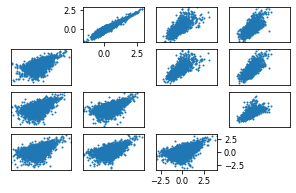

In [111]:
plt.figure(figsize=(5,3))

for i in range(4):
    for j in range(i, 4):
        
        if i == j:
            continue
            
        
        joined = all_result['ciliated']['ht'][stims[i]]['6'].merge(
            all_result['ciliated']['ht'][stims[j]]['6'], 
            on='gene', how='inner')
        
        print(stims[i], stims[j], i , j)
        print('de r', stats.pearsonr(joined['de_coef_y'], joined['de_coef_x']))
        print('dv r', stats.pearsonr(joined['dv_coef_y'], joined['dv_coef_x']))

        plt.subplot(4, 4, i*4+j+1);
        plt.scatter(joined['de_coef_y'], joined['de_coef_x'], s=1)
        plt.xlim(-1.5, 3); plt.ylim(-1.7, 3);
        if not (i == 0 and j == 1):
            plt.xticks([]); plt.yticks([])
        
        
        if (i == 2 and j == 3):
            plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = False
            plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = True
        plt.subplot(4, 4, j*4+i+1);
        plt.scatter(joined['dv_coef_y'], joined['dv_coef_x'], s=1)
        plt.xlim(-3, 4); plt.ylim(-3.5, 3.5);
        
        if (i == 2 and j == 3):
            plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True
            plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = False

        if not (i == 2 and j == 3):
            plt.xticks([]); plt.yticks([])
plt.savefig(fig_path + 'de_dv_corr_hbec.png', bbox_inches='tight', dpi=300)


### PBMC scatter plot

In [96]:
cm_ht_result_1d['de_fdr'] = memento.util._fdrcorrect(cm_ht_result_1d['de_pval'])
cm_ht_result_1d['dv_fdr'] = memento.util._fdrcorrect(cm_ht_result_1d['dv_pval'])

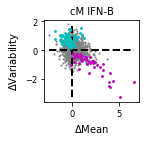

In [97]:
plt.figure(figsize=(1.7, 1.5))
plot_de_dv(cm_ht_result_1d)
plt.title('cM IFN-B')
plt.savefig(fig_path + 'scatter_pbmc_beta.png', bbox_inches='tight', dpi=300)


In [29]:
joined = all_result['ciliated']['ht']['beta']['6'].merge(
    all_result['ciliated']['ht']['lambda']['6'], 
    on='gene', how='inner')

In [30]:
stats.pearsonr(joined['de_coef_y'], joined['de_coef_x'])

(0.7109738257304512, 0.0)

In [31]:
stats.pearsonr(joined['dv_coef_y'], joined['dv_coef_x'])

(0.5927713194047084, 0.0)

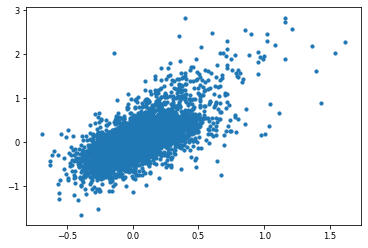

In [32]:
plt.scatter(joined['de_coef_y'], joined['de_coef_x'], s=10)

Text(0.5, 1.0, 'DV, IFN-A vs IFN-L')

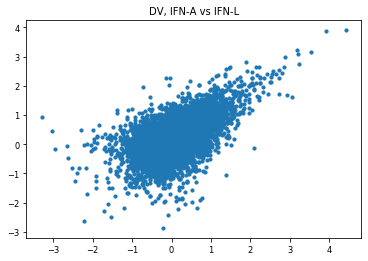

In [33]:
plt.scatter(joined['dv_coef_y'], joined['dv_coef_x'], s=10)
plt.title('DV, IFN-A vs IFN-L')

In [86]:
joined.query('dv_coef_y < -0.5 & dv_coef_x < -0.5')

,gene,de_coef_x,de_se_x,de_pval_x,dv_coef_x,dv_se_x,dv_pval_x,de_fdr_x,dv_fdr_x,de_coef_y,de_se_y,de_pval_y,dv_coef_y,dv_se_y,dv_pval_y,de_fdr_y,dv_fdr_y
3,ISG15,2.725120,0.072049,0.000001,-2.478389,0.170019,3.137984e-35,0.000009,3.025644e-31,2.823689,0.071810,6.528630e-05,-2.373462,0.170715,4.495823e-32,0.000286,4.274628e-28
9,B3GALT6,0.008483,0.160762,0.958404,-0.662819,0.708142,2.885711e-01,0.972218,6.605895e-01,-0.002782,0.161160,9.875012e-01,-0.521665,0.611430,3.414659e-01,0.990627,6.300519e-01
87,MTHFR,0.113527,0.114781,0.320568,-0.515171,0.624144,3.508649e-01,0.430550,7.107330e-01,0.146252,0.110489,1.838816e-01,-1.572584,0.800521,5.359464e-02,0.257982,2.605204e-01
100,CASP9,0.177427,0.152390,0.242476,-1.003639,0.823803,1.957804e-01,0.344069,5.749969e-01,0.208805,0.149745,1.610839e-01,-2.500267,0.871961,1.319868e-02,0.231008,1.100816e-01
110,ATP13A2,0.158050,0.130002,0.221478,-0.808901,0.718817,2.266773e-01,0.319445,6.058560e-01,0.113593,0.127685,3.695630e-01,-0.825404,0.622686,1.725827e-01,0.460706,4.682981e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9093,AL118516.1,-0.102205,0.152298,0.502350,-1.750895,0.684116,1.839816e-02,0.608882,1.758966e-01,-0.040380,0.149669,7.902210e-01,-0.854309,0.607530,1.375862e-01,0.840804,4.179457e-01
9110,TYMP,1.095519,0.037308,0.000053,-0.547484,0.169287,1.699830e-03,0.000300,2.969160e-02,1.135186,0.037023,5.492615e-07,-0.509907,0.171341,4.299570e-03,0.000004,4.572742e-02
9176,BCOR,-0.299576,0.159847,0.060994,-0.791149,0.619836,1.695830e-01,0.110733,5.477861e-01,-0.270654,0.154794,8.059194e-02,-0.678885,0.613393,2.151785e-01,0.128461,5.199054e-01
9341,RTL8C,-0.017714,0.160854,0.914209,-0.570172,0.777474,4.043596e-01,0.941249,7.500644e-01,0.045139,0.158972,7.720228e-01,-0.706387,0.825057,3.378662e-01,0.825320,6.266937e-01


### Finding examples of simple regulation

In [312]:
adata

AnnData object with n_obs × n_vars = 69958 × 36588
    obs: 'NUM.SNPS', 'BEST.GUESS', 'DROPLET.TYPE', 'batch', 'HTO_classification', 'condition', 'donor', 'stim', 'time', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [408]:
stim = 'beta'
ct = ['ciliated']
subset_processed = adata[
            adata.obs.cell_type.isin(ct) & \
            adata.obs.stim.isin(['control', stim])].copy()


In [409]:
# sc.pp.normalize_total(subset_processed, target_sum=1e4)

In [410]:
sc.pp.log1p(subset_processed)

In [411]:
df = pd.DataFrame()
df['STAT1'] = subset_processed[:, 'STAT1'].X.todense().A1
df['STAT2'] = subset_processed[:, 'STAT2'].X.todense().A1
df['IRF9'] = subset_processed[:, 'IRF9'].X.todense().A1

df['GBP1'] = subset_processed[:, 'GBP1'].X.todense().A1
df['ACTB'] = subset_processed[:, 'ACTB'].X.todense().A1

df['time'] = subset_processed.obs['time'].values

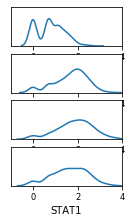

In [412]:
plt.figure(figsize=(2, 5))

for idx, time in enumerate(['0', '3', '9','48']):
    plt.subplot(6, 1, idx+1);
    sns.distplot(df.query('time == "{}"'.format(time)).STAT1, hist=False)
#     plt.hist(df.query('time == "{}"'.format(time)).STAT1, histtype='step', density=True)
    plt.yticks([])
    plt.xlim(-1, 4);
    plt.ylim(0, 1)

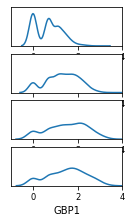

In [413]:
plt.figure(figsize=(2, 5))

for idx, time in enumerate(['0', '3', '9','48']):
    plt.subplot(6, 1, idx+1);
    sns.distplot(df.query('time == "{}"'.format(time)).GBP1, hist=False)
#     plt.hist(df.query('time == "{}"'.format(time)).STAT1, histtype='step', density=True)
    plt.yticks([])
    plt.xlim(-1, 4);
    plt.ylim(0, 1)

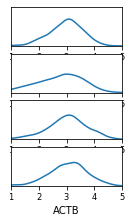

In [414]:
plt.figure(figsize=(2, 5))

for idx, time in enumerate(['0', '3', '9','48']):
    plt.subplot(6, 1, idx+1);
    sns.distplot(df.query('time == "{}"'.format(time)).ACTB, hist=False)
#     plt.hist(df.query('time == "{}"'.format(time)).STAT1, histtype='step', density=True)
    plt.yticks([])
    plt.xlim(1, 5);
    plt.ylim(0, 1)

(array([  7.,  15.,  31.,  50.,  80.,  99., 101.,  75.,  26.,  21.]),
 array([1.7747499, 1.9857469, 2.196744 , 2.4077408, 2.618738 , 2.8297348,
        3.040732 , 3.2517288, 3.4627259, 3.6737227, 3.8847198],
       dtype=float32),
 <a list of 1 Patch objects>)

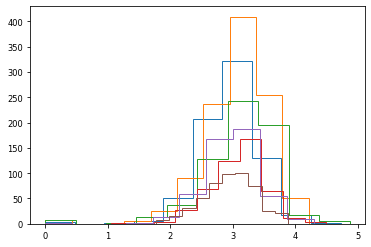

In [129]:
plt.hist(df.query('time == "0"').ACTB, histtype='step')
plt.hist(df.query('time == "3"').ACTB, histtype='step')
plt.hist(df.query('time == "6"').ACTB, histtype='step')
plt.hist(df.query('time == "9"').ACTB, histtype='step')
plt.hist(df.query('time == "24"').ACTB, histtype='step')
plt.hist(df.query('time == "48"').ACTB, histtype='step')

(array([0.3403083 , 0.        , 0.39864683, 0.32572369, 0.56393952,
        0.4229545 , 0.41323169, 0.25766193, 0.15070803, 0.03889237]),
 array([0.        , 0.34339872, 0.68679744, 1.0301962 , 1.3735949 ,
        1.7169936 , 2.0603924 , 2.403791  , 2.7471898 , 3.0905883 ,
        3.4339871 ], dtype=float32),
 <a list of 1 Patch objects>)

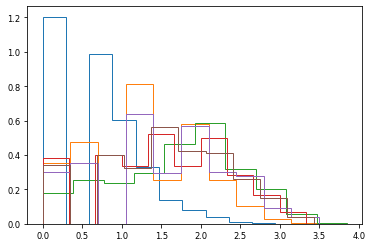

In [324]:
plt.hist(df.query('time == "0"').GBP1, histtype='step',density=True)
plt.hist(df.query('time == "3"').GBP1, histtype='step',density=True)
plt.hist(df.query('time == "6"').GBP1, histtype='step',density=True)
plt.hist(df.query('time == "9"').GBP1, histtype='step',density=True)
plt.hist(df.query('time == "24"').GBP1, histtype='step',density=True)
plt.hist(df.query('time == "48"').GBP1, histtype='step',density=True)

(array([0.12750858, 0.        , 0.        , 0.03731958, 0.15860823,
        0.23635736, 0.41984531, 0.61577312, 0.2519073 , 0.01554982]),
 array([0.        , 0.53680634, 1.0736127 , 1.610419  , 2.1472254 ,
        2.6840317 , 3.220838  , 3.7576444 , 4.2944508 , 4.831257  ,
        5.3680634 ], dtype=float32),
 <a list of 1 Patch objects>)

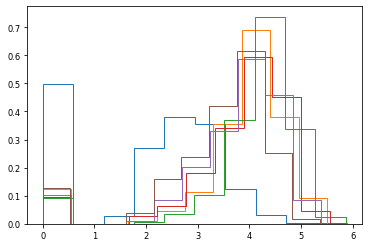

In [293]:
plt.hist(df.query('time == "0"').STAT1, histtype='step', density=True)
plt.hist(df.query('time == "3"').STAT1, histtype='step', density=True)
plt.hist(df.query('time == "6"').STAT1, histtype='step', density=True)
plt.hist(df.query('time == "9"').STAT1, histtype='step', density=True)
plt.hist(df.query('time == "24"').STAT1, histtype='step', density=True)
plt.hist(df.query('time == "48"').STAT1, histtype='step', density=True)

In [26]:
subset_processed[:, 'STAT1']

View of AnnData object with n_obs × n_vars = 4620 × 3064
    obs: 'NUM.SNPS', 'BEST.GUESS', 'DROPLET.TYPE', 'batch', 'HTO_classification', 'condition', 'donor', 'stim', 'time', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'donor_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'stim_colors', 'time_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [415]:
a = all_result['ciliated']['ht']['beta']['3'].query('de_pval > 0.6')
b = all_result['ciliated']['moments']['beta']['3'][0].query('time_step_0 > 1')

In [416]:
df = all_result['ciliated']['moments']['beta']['3'][1][['gene', 'time_step_0', 'time_step_1']]\
    .rename(columns={'time_step_1':'time_3', 'time_step_0':'time_0'})
mean_df = all_result['ciliated']['moments']['beta']['3'][0][['gene', 'time_step_0', 'time_step_1']]\
    .rename(columns={'time_step_1':'time_3', 'time_step_0':'time_0'})

In [417]:
for time in ['6', '9', '24', '48']:
    other = all_result['ciliated']['moments']['beta'][time][1][['gene', 'time_step_1']]
    mean_other = all_result['ciliated']['moments']['beta'][time][0][['gene', 'time_step_1']]
    df = df.merge(other, on='gene').rename(columns={'time_step_1':'time_'+time})
    mean_df = mean_df.merge(mean_other, on='gene').rename(columns={'time_step_1':'time_'+time})

In [418]:
X = df[['time_' + i for i in ['3','6', '9', '24', '48']]].values

In [419]:
X.shape

(8335, 5)

In [420]:
np.arange(6)

array([0, 1, 2, 3, 4, 5])

In [421]:
corrs = []
for i in range(X.shape[0]):
    corrs.append((df['gene'][i], stats.pearsonr(X[i, :], np.arange(5))[0]))

In [332]:
corr_df = pd.DataFrame(corrs, columns=['gene', 'corr'])

In [333]:
df.query('gene == "STAT1"')

,gene,time_0,time_3,time_6,time_9,time_24,time_48
1282,STAT1,0.371447,-0.039219,0.057358,0.353361,0.350871,0.428738


In [335]:
df.query('gene == "GBP1"')

,gene,time_0,time_3,time_6,time_9,time_24,time_48
390,GBP1,0.850509,0.468191,0.422282,0.85719,0.804174,0.859177


In [334]:
mean_df.query('gene == "STAT1"')

,gene,time_0,time_3,time_6,time_9,time_24,time_48
1282,STAT1,0.378762,1.201342,1.3782,1.082625,1.07682,0.906798


In [336]:
mean_df.query('gene == "GBP1"')

,gene,time_0,time_3,time_6,time_9,time_24,time_48
390,GBP1,0.238005,0.899781,1.14158,0.857399,0.864655,0.791893
